In [7]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import joblib
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report
from transformers import DistilBertForSequenceClassification, DistilBertTokenizer, AdamW
import torch
from torch.utils.data import DataLoader, TensorDataset
from selenium import webdriver
from bs4 import BeautifulSoup

# Part 1:  Preprocessing model

# Load the CSV file for the training dataset
df_train = pd.read_csv('Dataset - Training Data.csv')

# Preprocess the 'cleaned_website_text' column by filling NaN values with an empty string
df_train['cleaned_website_text'] = df_train['cleaned_website_text'].fillna('')

# Preprocess the data
X_train = df_train['cleaned_website_text'].values
y_train = df_train['Category'].values


In [4]:
df_train

,Unnamed: 0,website_url,cleaned_website_text,Category
0,1,http://www.selfstoragebrokersofamerica.com/,self storage brokers america let experience gu...,Business/Corporate
1,2,http://www.en.usz.ch/Pages/default.aspx,welcome university hospital zurich university ...,Health and Fitness
2,3,https://www.teen-chat.org/,free teen chat room teenagers free teen chat w...,Social Networking and Messaging
3,4,https://www.avjnews.com/,index index modified size description,News
4,5,http://imammb.oxfordjournals.org/,mathematical medicine biology journal ima oxfo...,Education
...,...,...,...,...
699,700,http://www.vaps.org/,vaps videogame arcade preservation society vid...,Games
700,701,http://www.appliedprobability.org/,applied probability trust study research mathe...,Education
701,702,http://www.angelfire.com/geek/alphabeta/,gravity gravity discuss gravity include histor...,Education
702,703,https://blog.yogamatters.com/,home yogamatter blog blog home want christmas ...,Health and Fitness


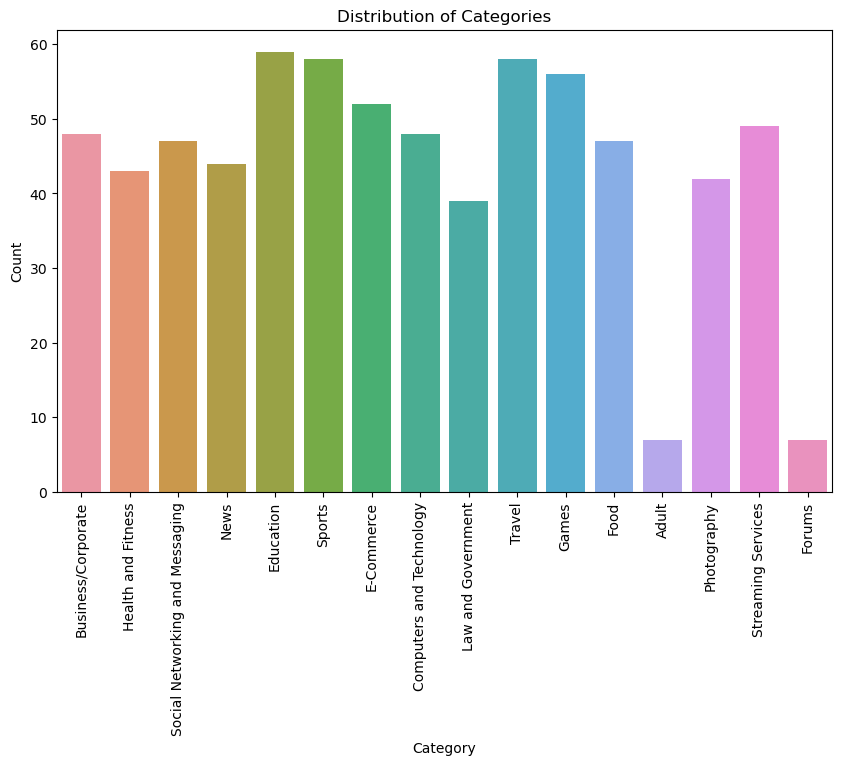

In [8]:
# Plot the distribution of categories in the training dataset
plt.figure(figsize=(10, 6))
sns.countplot(data=df_train, x='Category')
plt.xticks(rotation=90)
plt.xlabel('Category')
plt.ylabel('Count')
plt.title('Distribution of Categories')
plt.show()


In [ ]:
# Part 2: Fine-tune DistilBERT on training data

# Load the DistilBERT tokenizer and model for sequence classification
tokenizer = DistilBertTokenizer.from_pretrained('distilbert-base-uncased')
model_bert = DistilBertForSequenceClassification.from_pretrained('distilbert-base-uncased', num_labels=len(df_train['Category'].unique()))

# Tokenize the text data and obtain input tensors
encoded_data = tokenizer.batch_encode_plus(
    X_train,
    add_special_tokens=True,
    return_tensors='pt',
    padding=True,
    truncation=True,
    max_length=512
)

input_ids = encoded_data['input_ids']
attention_mask = encoded_data['attention_mask']

# Convert y_train into numeric labels
label_map = {category: i for i, category in enumerate(df_train['Category'].unique())}
y_train_numeric = [label_map[label] for label in y_train]
y_train_tensor = torch.tensor(y_train_numeric)

# Create a PyTorch DataLoader for the fine-tuning data
dataset = TensorDataset(input_ids, attention_mask, y_train_tensor)
train_dataloader = DataLoader(dataset, batch_size=1, shuffle=True)

# Set the model to training mode
model_bert.train()

# Define the optimizer and loss function for fine-tuning
optimizer = AdamW(model_bert.parameters(), lr=1e-5)
loss_fn = torch.nn.CrossEntropyLoss()

# Fine-tune the DistilBERT model on the training data
epochs = 3

for epoch in range(epochs):
    print(epoch)
    for batch in train_dataloader:
        print(batch)
        optimizer.zero_grad()
        input_ids, attention_mask, labels = batch
        outputs = model_bert(input_ids, attention_mask=attention_mask, labels=labels)
        loss = outputs.loss
        loss.backward()
        optimizer.step()

print("DistilBERT fine-tuning completed!")

Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing DistilBertForSequenceClassification: ['vocab_transform.weight', 'vocab_transform.bias', 'vocab_projector.bias', 'vocab_projector.weight', 'vocab_layer_norm.weight', 'vocab_layer_norm.bias']
- This IS expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['pre_classifier.bias', 'classifier.bias', 'classifier.w

0
[tensor([[  101,  3729,  2078, 18804, 19797,  2078,  2444, 11058,  4180,  6959,
          2897,  8116,  4180,  3435,  3177,  2825,  2444,  5460,  3565,  2659,
          2397,  9407, 18804, 19797,  2078,  6960,  2504,  2326,  4443,  2504,
          3976,  3443,  8116,  4180,  6959,  2897,  2444,  5460, 20874,  3729,
          2078, 20874,  2444, 11058, 20874,  2490,  8833,  2378,  3729,  2078,
          2444, 11058,  3444, 20874,  2897,  6325,  4800,  3729,  2078,  8346,
          5009,  2707,  3979,  3444, 20874,  2897,  6325,  2444,  5460, 10250,
         19879,  4263,  2678,  5157,  2678,  4372, 16044,  2707,  3979,  4180,
          6959,  2897,  3729,  2078,  2444, 11058,  4180,  6959,  2897,  2707,
          3979,  2444, 11058,  3979,  9199,  8167,  2243,  4800,  3729,  2078,
          3674,  4895,  8757,  3729,  2078,  3073,  5621,  3795,  2897,  3435,
          2799, 10367,  3435,  2897,  2555,  2307,  3643,  2152,  3737,  2326,
          2204,  3643,  3446,  2659,  2397,  9407

In [9]:
# Store the training loss values during fine-tuning
train_losses = []

# Inside the fine-tuning loop:
for epoch in range(epochs):
    # ... (other code)
    train_losses.append(loss.item())

# Plot the training loss over epochs
plt.figure(figsize=(8, 5))
plt.plot(range(1, epochs+1), train_losses, marker='o')
plt.xlabel('Epoch')
plt.ylabel('Training Loss')
plt.title('Training Loss Over Epochs')
plt.grid()
plt.show()


NameError: name 'epochs' is not defined

In [5]:
# Part 3: Use the fine-tuned DistilBERT model to classify the given URL

# Configure Selenium webdriver
driver = webdriver.Chrome()  # (executable_path=webdriver_path)
url = 'https://www.netflix.com/browse'  # Replace with the URL you want to classify
driver.get(url)

# Retrieve the HTML content
html_content = driver.page_source

# Close the Selenium webdriver
driver.quit()

# Create a BeautifulSoup object to parse the HTML
soup = BeautifulSoup(html_content, 'html.parser')

# Extract relevant information from the parsed HTML
description = soup.find('meta', {'name': 'description'})['content']

description = soup.get_text()

# Load the DistilBERT tokenizer
tokenizer = DistilBertTokenizer.from_pretrained('distilbert-base-uncased')

# Preprocess the description
preprocessed_description = tokenizer.encode_plus(description, add_special_tokens=True, truncation=True,
                                                 max_length=512, padding='max_length', return_tensors='pt')

# Obtain the input tensors
input_ids = preprocessed_description['input_ids']
attention_mask = preprocessed_description['attention_mask']

# Set the model to evaluation mode
model_bert.eval()

# Perform inference on the input tensors using the fine-tuned DistilBERT model
with torch.no_grad():
    outputs = model_bert(input_ids, attention_mask=attention_mask)
    logits = outputs.logits

# Get the predicted category
predicted_category = torch.argmax(logits, dim=1).item()

# Define the category mapping (same as in the provided code)
category_mapping = {
    0: 'Business/Corporate',
    1: 'Health and Fitness',
    2: 'Social Networking and Messaging',
    3: 'News',
    4: 'Education',
    5: 'Sports',
    6: 'E-Commerce',
    7: 'Computers and Technology',
    8: 'Law and Government',
    9: 'Travel',
    10: 'Games',
    11: 'Food',
    12: 'Adult',
    13: 'Photography',
    14: 'Streaming Services',
    15: 'Forums'
}

# Get the predicted category label
predicted_category_label = category_mapping[predicted_category]

# Print the predicted category label
print(f"URL: {url}")
print(f"Predicted Category: {predicted_category_label}")

Error getting version of chromedriver 115. Retrying with chromedriver 114 (attempt 1/5)


NameError: name 'model_bert' is not defined